In [24]:
figDir = '~/Hyphosphere/data/3Exp/figures'

work_dir = '~/Hyphosphere/data/3Exp/Composition'

# phyloseq - full object without tree (includes archaea)
physeq_file = '~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_woTree_woContam.rds'

In [25]:
library(RColorBrewer)
library(tidyr)
library(dplyr)
library(reshape2)
library(phyloseq)
library(gridExtra)
library(ggplot2)
library(DESeq2)

In [26]:
theme_pub = function (base_size = 11, base_family = "Arial") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

In [27]:
ps = readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    subset_samples(., !SampleType %in% c("EB", "PB", "MK")) %>%
    # T0R1 has all NaN for some reason
    subset_samples(!Sample == "T0R1") %>%
     # re-normalize after subsetting taxa
    transform_sample_counts(., function(x) x/sum(x))
sample_data(ps)$Rep = as.factor(sample_data(ps)$Rep)

ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15128 taxa and 398 samples ]
sample_data() Sample Data:       [ 398 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 15128 taxa by 6 taxonomic ranks ]

In [28]:
ps.m = psmelt(ps)

Warning message in psmelt(ps):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”

In [29]:
ps.m1 = ps.m %>% filter(Experiment == 1)
ps.m2 = ps.m %>% filter(Experiment == 2)
ps.m3 = ps.m %>% filter(Experiment == 3)

# Resume here, finding way to efficiently convert low abundance groups to same color

Sample,SampleType,Soil,Rep,Phylum,s.Abundance,mAbundance,graphRank
HCBF1_S247,CS,Florence,1,Acidobacteria,0.110342133,0.0649475840,Acidobacteria
HCBF1_S247,CS,Florence,1,Actinobacteria,0.164369035,0.0456599000,Actinobacteria
HCBF1_S247,CS,Florence,1,Armatimonadetes,0.005860356,0.0149415592,Armatimonadetes
HCBF1_S247,CS,Florence,1,Bacteroidetes,0.042808506,0.1085221003,Bacteroidetes
HCBF1_S247,CS,Florence,1,BRC1,0.000000000,0.0008400538,Max less than 2% rel abundance
HCBF1_S247,CS,Florence,1,Chlamydiae,0.001674387,0.0174339503,Chlamydiae


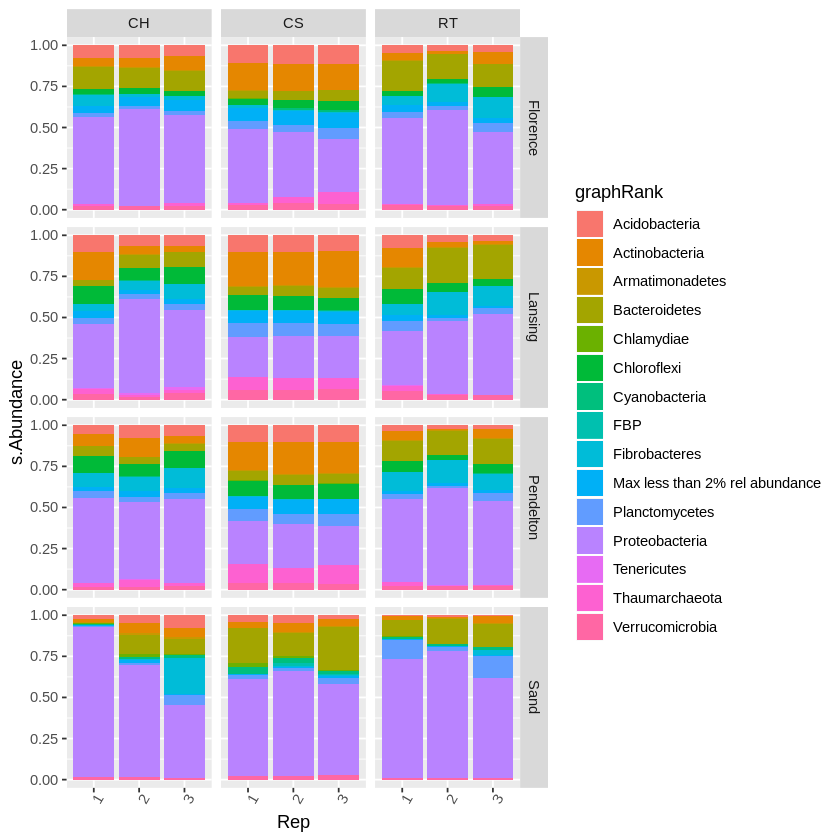

In [64]:
# Identify phyla with max abundance less than 0.01
PMap = ps.m1 %>% 
    group_by(Phylum) %>%
    summarize(mAbundance = max(Abundance)) %>%
    mutate(graphRank = factor(ifelse(mAbundance > 0.01, as.character(Phylum), 'Max less than 2% rel abundance')))

#generate data frame of samples aggregated at the phylum level 
tmp = ps.m1 %>% 
    group_by(Sample,SampleType,Soil, Rep, Phylum) %>%
    summarize(.,s.Abundance = sum(Abundance)) 

# join df with phylum graphing attribute
tmp = left_join(tmp, PMap, by = "Phylum")

head(tmp)


# #goal is to calculate relative abundance 
#   # cast by Rank2
# #   R2.c = dcast(Rank2.df, Soil + SampleType ~ Phylum)
# #   head(R2.c)
# #   #Calculate relative abundance using 
# #   R2.c[,3:23] = sweep(R2.c[,3:23], 1, rowSums(R2.c[,3:23]), '/')
# #   head(R2.c)
# # R2.m = melt(R2.c, id.vars = c("Soil", "SampleType"))
  

# ##getPalette = colorRampPalette(brewer.pal(colorCount, "Set2"))

ggplot(tmp, aes(x = Rep, y = s.Abundance, fill=graphRank)) + 
    geom_bar(stat = "identity")+
    theme(axis.text.x = element_text(angle = 60))+
    #scale_fill_manual(values = getPalette(colourCount))+
    facet_grid(Soil~SampleType, scales = 'free_x') 

Sample,SampleType,Treatment,Fungus,Soil,Rep,Phylum,s.Abundance,mAbundance,graphRank
1_GVCLHN1-BH,BH,HN,Gv,Pendelton,1,Acidobacteria,0.100872776,0.047246102,Acidobacteria
1_GVCLHN1-BH,BH,HN,Gv,Pendelton,1,Actinobacteria,0.250923129,0.111024787,Actinobacteria
1_GVCLHN1-BH,BH,HN,Gv,Pendelton,1,Armatimonadetes,0.008475999,0.026744898,Armatimonadetes
1_GVCLHN1-BH,BH,HN,Gv,Pendelton,1,Bacteroidetes,0.006159785,0.102100635,Bacteroidetes
1_GVCLHN1-BH,BH,HN,Gv,Pendelton,1,BRC1,0.000000000,0.001071811,Max less than 2% rel abundance
1_GVCLHN1-BH,BH,HN,Gv,Pendelton,1,Chlamydiae,0.000000000,0.011560361,Chlamydiae


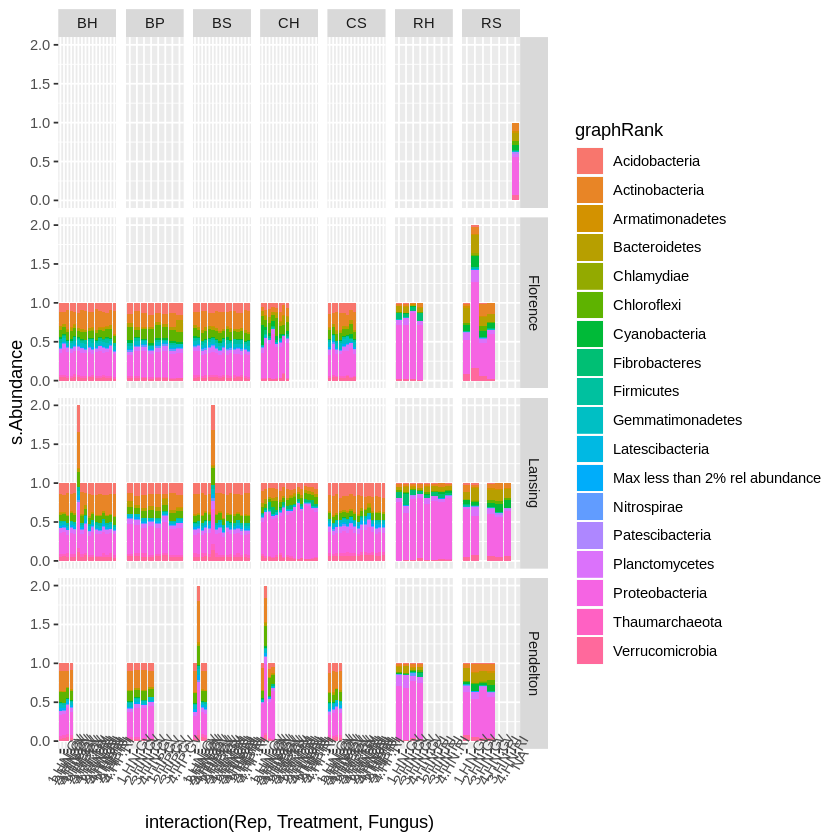

In [74]:
# Identify phyla with max abundance less than 0.01
PMap = ps.m2 %>% 
    group_by(Phylum) %>%
    summarize(mAbundance = max(Abundance)) %>%
    mutate(graphRank = factor(ifelse(mAbundance > 0.01, as.character(Phylum), 'Max less than 2% rel abundance')))

#generate data frame of samples aggregated at the phylum level 
tmp = ps.m2 %>% 
    group_by(Sample,SampleType,Treatment, Fungus, Soil, Rep, Phylum) %>%
    summarize(.,s.Abundance = sum(Abundance)) 

# join df with phylum graphing attribute
tmp = left_join(tmp, PMap, by = "Phylum")

head(tmp)


# # #goal is to calculate relative abundance 
# #   # cast by Rank2
# # #   R2.c = dcast(Rank2.df, Soil + SampleType ~ Phylum)
# # #   head(R2.c)
# # #   #Calculate relative abundance using 
# # #   R2.c[,3:23] = sweep(R2.c[,3:23], 1, rowSums(R2.c[,3:23]), '/')
# # #   head(R2.c)
# # # R2.m = melt(R2.c, id.vars = c("Soil", "SampleType"))
  

# # ##getPalette = colorRampPalette(brewer.pal(colorCount, "Set2"))

ggplot(tmp, aes(x = interaction(Rep,Treatment,Fungus), y = s.Abundance, fill=graphRank)) + 
    geom_bar(stat = "identity")+
    theme(axis.text.x = element_text(angle = 60))+
    #scale_fill_manual(values = getPalette(colourCount))+
    facet_grid(Soil~SampleType, scales = 'free_x') 

### which samples are duplicated?

In [79]:
Duplicates = ps %>%
    sample_data() %>%
    as.data.frame() %>%
    group_by(Sample) %>%
    summarize(n = length(Sample)) %>%
    filter(n >= 2) %>% 
    .$Sample %>% 
    as.character()

In [99]:
readRDS(physeq_file) %>% subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    subset_samples(., !SampleType %in% c("EB", "PB", "MK")) %>%
    # T0R1 has all NaN for some reason
    subset_samples(!Sample == "T0R1") %>%
    subset_samples(Sample %in% Duplicates) %>%
    sample_sums()

25_2.3CH       26_2.3CH       53_1.3BS       54_1.3BS  19_GVN7HP2-BH 
         78127          31054          26836          31474          46000 
190_GVN7HP2-BH 191_GVCLHN2-BS  20_GVN7HP2-BS   4_GVCLHN2-BS  64_GVCLHN2-CH 
          4850          10318          27935          68443          17272 
 72_GVFLHN2-RS  94_GVN7HP2-BS  95_GVCLHN2-CH  96_GVFLHN2-RS 
         17387           2662          19253          29005

In [90]:
tmp = ps %>%
    subset_samples(Experiment == 3) %>%
    sample_data() %>% 
    filter(SampleType %in% c("CS") & TimePoint %in% c(5))


Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
5.5CS,3,5.5,Gv,Lansing,CS,HN,5,65,5,0.218
6.5CS,3,6.5,Gv,Lansing,CS,HN,5,65,6,0.332
2.5CS,3,2.5,Gv,Lansing,CS,HN,5,65,2,2.188
1.5CS,3,1.5,Gv,Lansing,CS,HN,5,65,1,0.937
4.5CS,3,4.5,Gv,Lansing,CS,HN,5,65,4,0.406


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7782 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 7782 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7782 tips and 7781 internal nodes ]

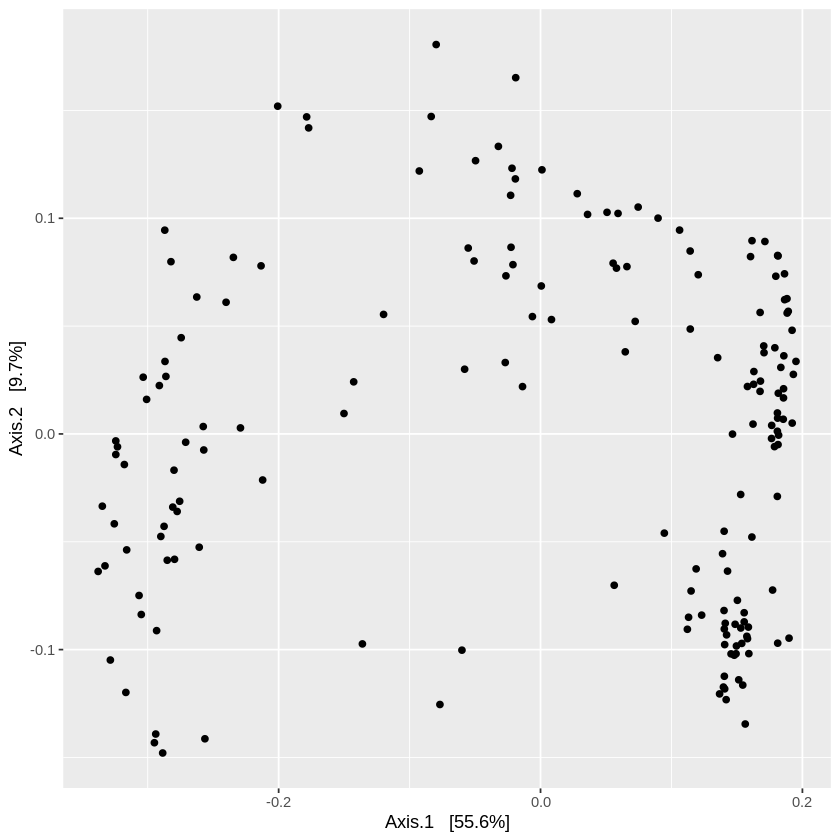

In [122]:

tmp = readRDS('~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_wtree_woContam.rds') %>%
    subset_samples(Experiment == 3) %>%
    subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    subset_samples(., SampleType %in% c("BP", "BS", "CH", "CS", "RH", "RT")) %>%
    # T0R1 has all NaN for some reason
    subset_samples(!Sample == "T0R1") %>%
     # re-normalize after subsetting taxa
    filter_taxa(., function(x) sum(x > 3) > 3, TRUE) %>%
    transform_sample_counts(., function(x) x/sum(x))
 tmp   
sample_data(tmp)$Rep = as.factor(sample_data(tmp)$Rep)
    

ordu = ordinate(tmp, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(tmp, ordu, justDF = TRUE)
plot_ordination(tmp, ordu)

In [107]:
head(p)

,Axis.1,Axis.2,Sample,Experiment,Plant,Fungus,Soil,SampleType,Treatment,TimePoint,DAI,Rep,Concentration_ng.ul
1_3.1RH,-0.20974829,-0.02060019,3.1RH,3,3.1,Gv,Lansing,RH,HN,1,14,3,0.184
10_2.1RH,-0.05204405,0.02942446,2.1RH,3,2.1,Gv,Lansing,RH,HN,1,14,2,0.178
100_5.5BP,0.13971987,-0.08197358,5.5BP,3,5.5,Gv,Lansing,BP,HN,5,65,5,2.065
101_5.5CS,0.14189904,-0.12439282,5.5CS,3,5.5,Gv,Lansing,CS,HN,5,65,5,0.218
102_5.5BS,0.15861160,-0.09603758,5.5BS,3,5.5,Gv,Lansing,BS,HN,5,65,5,2.797
103_6.5BP,0.11495266,-0.07391719,6.5BP,3,6.5,Gv,Lansing,BP,HN,5,65,6,1.001


Warning message in brewer.pal(2, "Dark2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

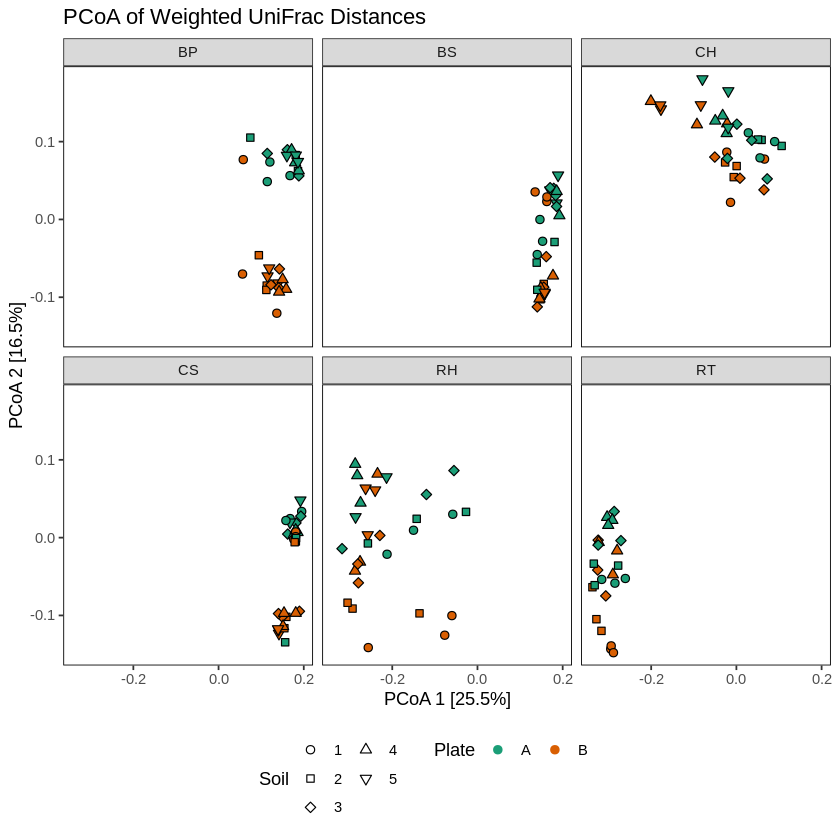

In [123]:
p = p %>% mutate(Plate = ifelse(Rep %in% c(1,2,3), "A", "B"))

#setwd(figDir)
#tmp = filter(p, SampleType %in% c("BS", "BH") & Soil == "Lansing")
#tmp2 = filter(p, Sample == "1.3BS")
cs = brewer.pal(2,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(TimePoint), fill = Plate),  size = 2) +
#geom_point(data = tmp2, aes(x = Axis.1, y = Axis.2), shape = 8, size = 8)+
theme_pub() +
scale_shape_manual(values=c(21,22,23,24,25), guide = guide_legend(title = "Soil", ncol = 2))+
scale_fill_manual(values = cs)+
labs(x = "PCoA 1 [25.5%]", y = "PCoA 2 [16.5%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
guides(fill=guide_legend(override.aes=list(color= cs[1:2]), ncol = 3))+
facet_wrap(~SampleType)+
#guides(fill=guide_legend(override.aes=list(color= cs), ncol = 3), shape = guide_legend(override.aes=list(shape = c(21,22,23,24), ncol = 2))) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

# Check why we are seeing batch effect

In [150]:
Ctm1 = read.delim('~/Hyphosphere/Exp10/ContaminantSeqTab_original.txt', sep = '\t', header = TRUE)
head(Ctm1)
Sdf = read.delim('~/Hyphosphere/data/3Exp/phyloseq/taxa_seqs.txt', sep = '\t')
head(Sdf)

OrigOTU,Seq
ASV1,TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTATTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGTAGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
ASV3,TACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
ASV25,TATGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTATTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGTAGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
ASV49,TATGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
ASV4,GACGGGGGGGGCAAGTGTTCTTCGGAATGACTGGGCGTAAAGGGCACGTAGGCGGTGAATCGGGTTGAAAGTGAAAGTCGCCAAAAAGTGGCGGAATGCTCTCGAAACCAATTCACTTGAGTGAGACAGAGGAGAGTGGAATTTCGTGTGTAGGGGTGAAATCCGTAGATCTACGAAGGAACGCCAAAAGCGAAGGCAGCTCTCTGGGTCCCTACCGACGCTGGGGTGCGAAAGCATGGGGAGCGAACAGG
ASV7,GACAGAGGATGCAAGCGTTATCCGGAATGATTGGGCGTAAAGCGTCTGTAGGTGGCTTTTCAAGTCCGCCGTCAAATCCCAGGGCTCAACCCTGGACAGGCGGTGGAAACTACCAAGCTGGAGTACGGTAGGGGCAGAGGGAATTTCCGGTGGAGCGGTGAAATGCATTGAGATCGGAAAGAACACCAACGGCGAAAGCACTCTGCTGGGCCGACACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATGGG


,ASV,Seq
ASV1,ASV1,TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTATTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGTAGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
ASV2,ASV2,GACATAGGTGGCAAACATTATCCGGAATTATTGGGCGTAAAGGGTGCGTAGGCGGCATGATAAGTTGCTGGTGGGAAATCAAGGCTCAACCTTGTGGAAGCTAGCAATACTGTCAAGCTAGAGGGCAGAAGAGGTTAACGGAACTCTATGTGGAGCGGTAAAATGTGTAGATATATAGAAGAACATCAATAAAGGCGAAGGCAGTTAACTAGTCTGTCCCTGACGTTGAGGCACGAAAGCGTGGGGAGCAAAACGG
ASV3,ASV3,TACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
ASV4,ASV4,GACATAGGTGGCGAACGTTATCCGGAATTATTGGGCGTAAAGGATGCGTAGATGGCAGAGTAAGTTACTGGTTGATGTCAAACTCAATTTGACGGAAGCTGGTAATACTGTTTTGCTAGAGGACAGGAGAGGTTGATGGAATTCTGTGTGGAGCGGTGAAATGCGTTGATCTACAGAGGAACACCAAAAAAGGCGAAGGCAGTCAACTATCCTGTTCCTGACATTGAGGCATGAAAGCGTGGGGAGCAAACCGG
ASV5,ASV5,TACGTAGGGCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCGCGTCTGCCGTGAAAGTCCGGGGCTCAACTCCGGATCTGCGGTGGGTACGGGCAGACTAGAGTGATGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCATTAACTGACGCTGAGGAGCGAAAGCATGGGGAGCGAACAGG
ASV6,ASV6,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGTAGGTGGTTTGTTAAGCTAGCTGTGAAATCCCCGGGCTCAACCTGGGCACTGCAGTTAGAACTGGCAAGCTAGAGTAGGGTAGAGGGGTGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACACCCTGGACTCATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG


In [157]:
Ctm2 = left_join(Ctm1, Sdf, by = 'Seq')
Ctm2
Ctm2 = Ctm2$ASV %>% as.character()

Warning message:
“Column `Seq` joining factors with different levels, coercing to character vector”

OrigOTU,Seq,ASV
ASV1,TACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTATTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGTAGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,ASV1
ASV3,TACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,ASV3
ASV25,TATGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTATTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGTAGTCTTGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,ASV54
ASV49,TATGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTCAGAGGTGAAAGCCTGGAGCTCAACTCCAGAACTGCCTTTGAGACTGCATCGCTTGAATCCAGGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGGCTCACTGGACTGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG,ASV136
ASV4,GACGGGGGGGGCAAGTGTTCTTCGGAATGACTGGGCGTAAAGGGCACGTAGGCGGTGAATCGGGTTGAAAGTGAAAGTCGCCAAAAAGTGGCGGAATGCTCTCGAAACCAATTCACTTGAGTGAGACAGAGGAGAGTGGAATTTCGTGTGTAGGGGTGAAATCCGTAGATCTACGAAGGAACGCCAAAAGCGAAGGCAGCTCTCTGGGTCCCTACCGACGCTGGGGTGCGAAAGCATGGGGAGCGAACAGG,ASV7
ASV7,GACAGAGGATGCAAGCGTTATCCGGAATGATTGGGCGTAAAGCGTCTGTAGGTGGCTTTTCAAGTCCGCCGTCAAATCCCAGGGCTCAACCCTGGACAGGCGGTGGAAACTACCAAGCTGGAGTACGGTAGGGGCAGAGGGAATTTCCGGTGGAGCGGTGAAATGCATTGAGATCGGAAAGAACACCAACGGCGAAAGCACTCTGCTGGGCCGACACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATGGG,ASV10


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7799 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 7799 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7799 tips and 7798 internal nodes ]

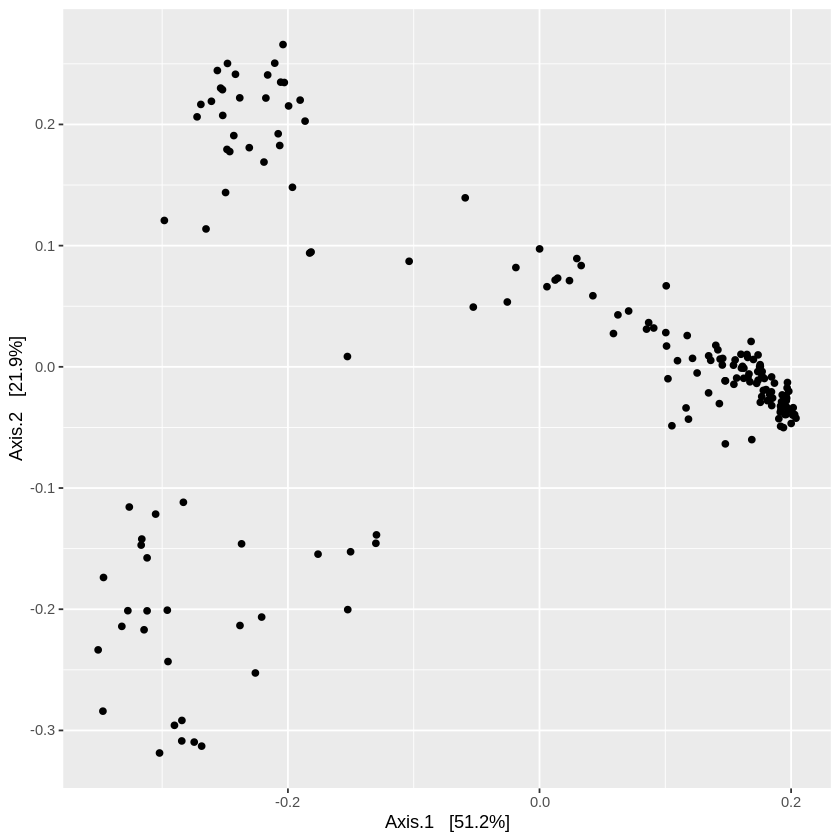

In [158]:

tmp = readRDS('~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_wtree.rds') %>%
    subset_samples(Experiment == 3) %>%
    subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    subset_samples(., SampleType %in% c("BP", "BS", "CH", "CS", "RH", "RT")) %>%
    # T0R1 has all NaN for some reason
    subset_samples(!Sample == "T0R1") %>%
     # re-normalize after subsetting taxa
    filter_taxa(., function(x) sum(x > 3) > 3, TRUE) %>%
    transform_sample_counts(., function(x) x/sum(x))
 tmp   
sample_data(tmp)$Rep = as.factor(sample_data(tmp)$Rep)
    

ordu = ordinate(tmp, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(tmp, ordu, justDF = TRUE)
plot_ordination(tmp, ordu)

Warning message in brewer.pal(2, "Dark2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

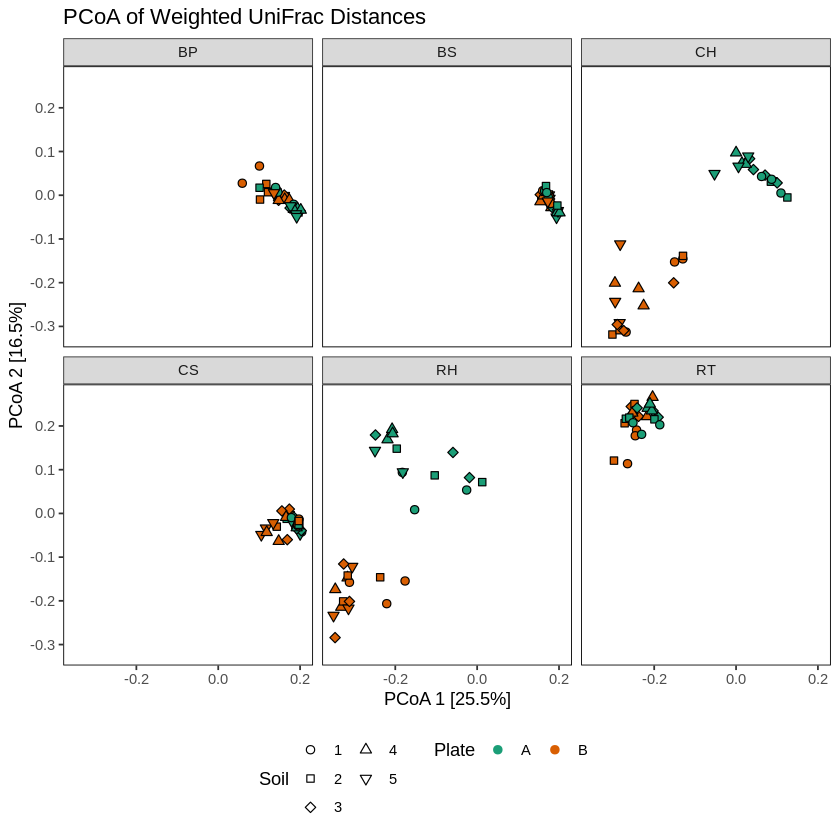

In [159]:
p = p %>% mutate(Plate = ifelse(Rep %in% c(1,2,3), "A", "B"))

#setwd(figDir)
#tmp = filter(p, SampleType %in% c("BS", "BH") & Soil == "Lansing")
#tmp2 = filter(p, Sample == "1.3BS")
cs = brewer.pal(2,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(TimePoint), fill = Plate),  size = 2) +
#geom_point(data = tmp2, aes(x = Axis.1, y = Axis.2), shape = 8, size = 8)+
theme_pub() +
scale_shape_manual(values=c(21,22,23,24,25), guide = guide_legend(title = "Soil", ncol = 2))+
scale_fill_manual(values = cs)+
labs(x = "PCoA 1 [25.5%]", y = "PCoA 2 [16.5%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
guides(fill=guide_legend(override.aes=list(color= cs[1:2]), ncol = 3))+
facet_wrap(~SampleType)+
#guides(fill=guide_legend(override.aes=list(color= cs), ncol = 3), shape = guide_legend(override.aes=list(shape = c(21,22,23,24), ncol = 2))) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

In [154]:
testC = c(Ctm2)#, "ASV78", "ASV136", "ASV12")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7799 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 7799 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7799 tips and 7798 internal nodes ]

[1] 7795

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7795 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 7795 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7795 tips and 7794 internal nodes ]

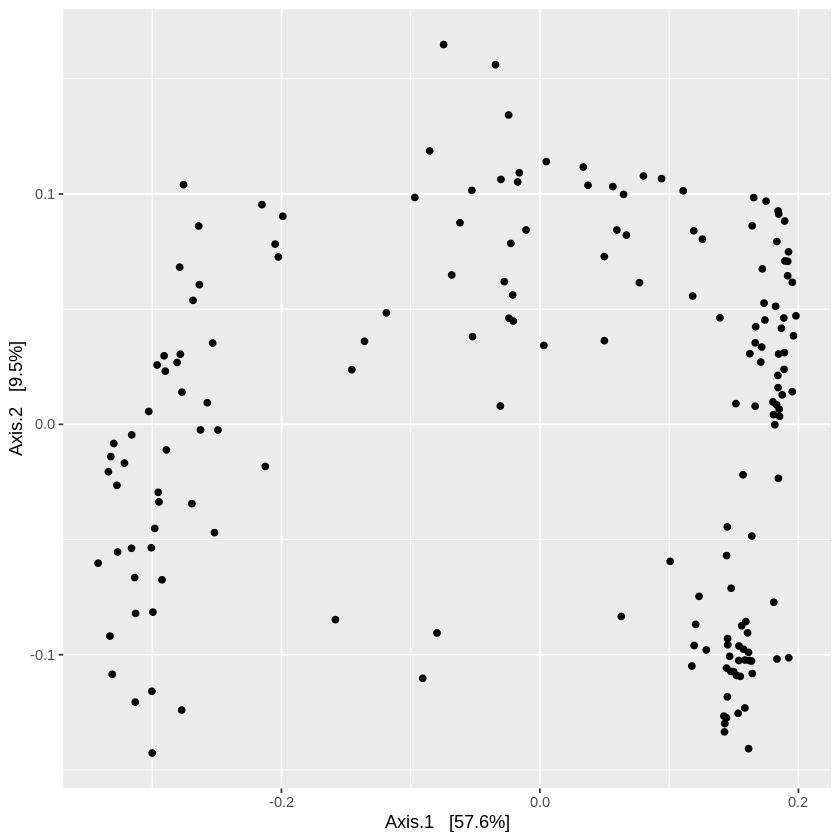

In [160]:


tmp = readRDS('~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_wtree.rds') %>%
    subset_samples(Experiment == 3) %>%
    subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    subset_samples(., SampleType %in% c("BP", "BS", "CH", "CS", "RH", "RT")) %>%
    # T0R1 has all NaN for some reason
    subset_samples(!Sample == "T0R1") %>%
     # re-normalize after subsetting taxa
    filter_taxa(., function(x) sum(x > 3) > 3, TRUE)
tmp
                
 # define taxa to remove
all_taxa = taxa_names(tmp)
all_taxa = all_taxa[!(all_taxa %in% testC)]

all_taxa %>% length                
tmp = prune_taxa(all_taxa, tmp) %>%
    transform_sample_counts(., function(x) x/sum(x)) 
tmp   
sample_data(tmp)$Rep = as.factor(sample_data(tmp)$Rep)
    
ordu = ordinate(tmp, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(tmp, ordu, justDF = TRUE)
plot_ordination(tmp, ordu)


Warning message in brewer.pal(2, "Dark2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

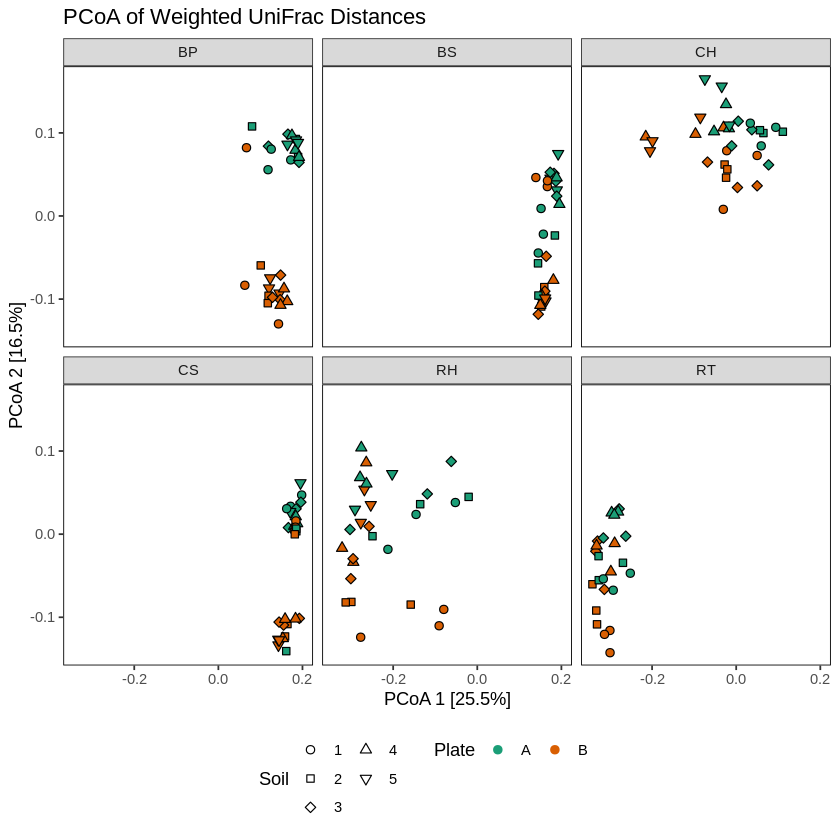

In [156]:
p = p %>% mutate(Plate = ifelse(Rep %in% c(1,2,3), "A", "B"))

#setwd(figDir)
#tmp = filter(p, SampleType %in% c("BS", "BH") & Soil == "Lansing")
#tmp2 = filter(p, Sample == "1.3BS")
cs = brewer.pal(2,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(TimePoint), fill = Plate),  size = 2) +
#geom_point(data = tmp2, aes(x = Axis.1, y = Axis.2), shape = 8, size = 8)+
theme_pub() +
scale_shape_manual(values=c(21,22,23,24,25), guide = guide_legend(title = "Soil", ncol = 2))+
scale_fill_manual(values = cs)+
labs(x = "PCoA 1 [25.5%]", y = "PCoA 2 [16.5%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
guides(fill=guide_legend(override.aes=list(color= cs[1:2]), ncol = 3))+
facet_wrap(~SampleType)+
#guides(fill=guide_legend(override.aes=list(color= cs), ncol = 3), shape = guide_legend(override.aes=list(shape = c(21,22,23,24), ncol = 2))) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

In [161]:
FC.o = c("ASV1", 
"ASV54" ,
"ASV78", 
"ASV136", 
"ASV3", 
"ASV12",
"ASV2516",
"ASV681", 
"ASV447",
"ASV49", 
"ASV12695", 
"ASV2395", 
"ASV284", 
"ASV1706", 
"ASV1900", 
"ASV26", 
"ASV14332", 
"ASV2962",
"ASV9101",
"ASV2180", 
"ASV8061", 
"ASV4437", 
"ASV6987", 
"ASV2714",
"ASV2160", 
"ASV2117", 
"ASV2704", 
"ASV1002", 
"ASV4083",
"ASV7871", 
"ASV1900", 
"ASV171", 
"ASV2516", 
"ASV8536",
"ASV285", 
"ASV3225", 
"ASV5265", 
"ASV2962", 
"ASV14282")
testC = c(Ctm2, FC.o)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7799 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 7799 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7799 tips and 7798 internal nodes ]

[1] 7782

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7782 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 7782 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7782 tips and 7781 internal nodes ]

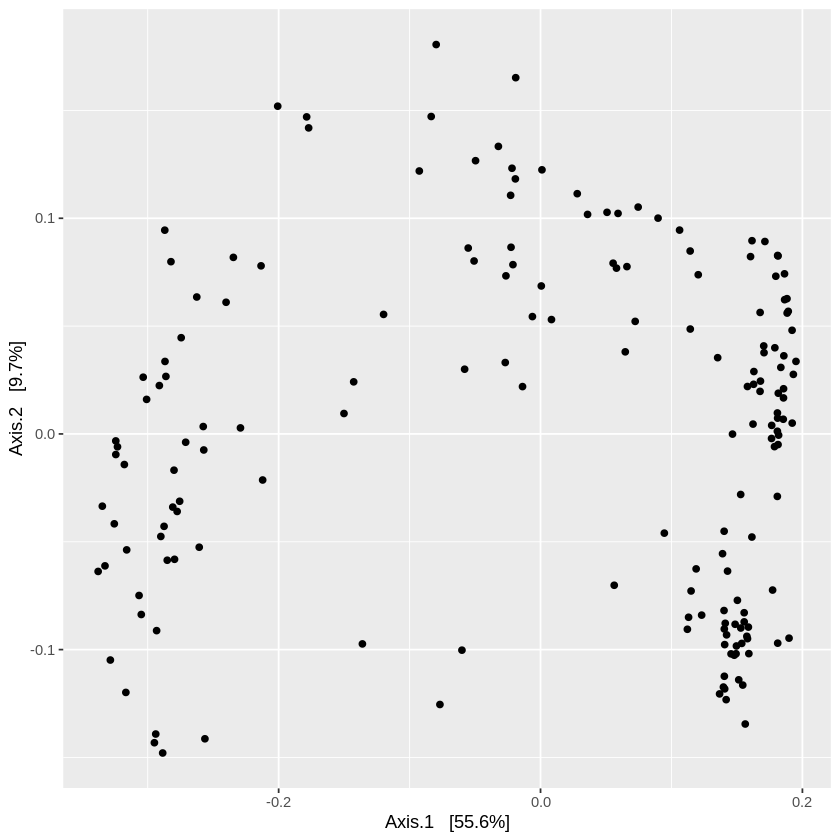

In [162]:


tmp = readRDS('~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_wtree.rds') %>%
    subset_samples(Experiment == 3) %>%
    subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    subset_samples(., SampleType %in% c("BP", "BS", "CH", "CS", "RH", "RT")) %>%
    # T0R1 has all NaN for some reason
    subset_samples(!Sample == "T0R1") %>%
     # re-normalize after subsetting taxa
    filter_taxa(., function(x) sum(x > 3) > 3, TRUE)
tmp
                
 # define taxa to remove
all_taxa = taxa_names(tmp)
all_taxa = all_taxa[!(all_taxa %in% testC)]

all_taxa %>% length                
tmp = prune_taxa(all_taxa, tmp) %>%
    transform_sample_counts(., function(x) x/sum(x)) 
tmp   
sample_data(tmp)$Rep = as.factor(sample_data(tmp)$Rep)
    
ordu = ordinate(tmp, "PCoA", "unifrac", weighted=TRUE)
p = plot_ordination(tmp, ordu, justDF = TRUE)
plot_ordination(tmp, ordu)

Warning message in brewer.pal(2, "Dark2"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

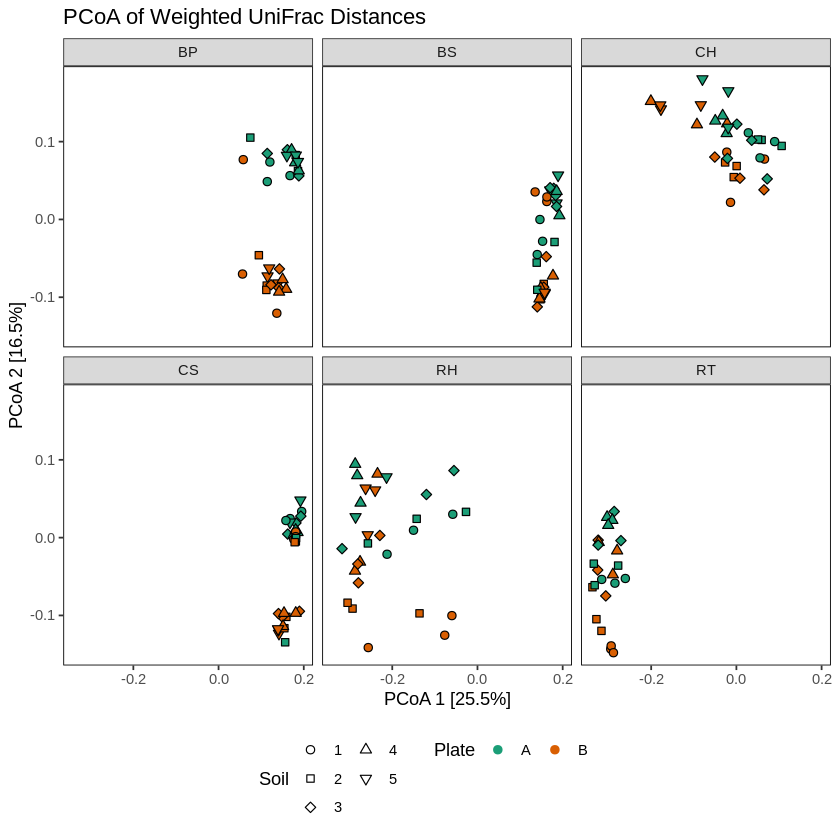

In [163]:
p = p %>% mutate(Plate = ifelse(Rep %in% c(1,2,3), "A", "B"))

#setwd(figDir)
#tmp = filter(p, SampleType %in% c("BS", "BH") & Soil == "Lansing")
#tmp2 = filter(p, Sample == "1.3BS")
cs = brewer.pal(2,"Dark2")
p1 = ggplot(p, aes(x = Axis.1, y = Axis.2)) +
geom_point(aes(shape = as.factor(TimePoint), fill = Plate),  size = 2) +
#geom_point(data = tmp2, aes(x = Axis.1, y = Axis.2), shape = 8, size = 8)+
theme_pub() +
scale_shape_manual(values=c(21,22,23,24,25), guide = guide_legend(title = "Soil", ncol = 2))+
scale_fill_manual(values = cs)+
labs(x = "PCoA 1 [25.5%]", y = "PCoA 2 [16.5%]") +
ggtitle("PCoA of Weighted UniFrac Distances")+
guides(fill=guide_legend(override.aes=list(color= cs[1:2]), ncol = 3))+
facet_wrap(~SampleType)+
#guides(fill=guide_legend(override.aes=list(color= cs), ncol = 3), shape = guide_legend(override.aes=list(shape = c(21,22,23,24), ncol = 2))) + 
theme(legend.position="bottom") 

#color = "grey20",

p1

# Try using DESeq2 to identify contaminants

In [193]:
tmp = readRDS('~/Hyphosphere/data/3Exp/phyloseq/3Exp_phyloseq_thresh_wtree.rds') %>%
    subset_samples(Experiment == 3) %>%
    subset_taxa(., !is.na(Phylum)) %>%
    # remove non-experimental controls
    subset_samples(., SampleType %in% c("BP", "BS", "CH", "CS", "RH", "RT")) %>%
    # T0R1 has all NaN for some reason
    subset_samples(!Sample == "T0R1") %>%
     # re-normalize after subsetting taxa
    filter_taxa(., function(x) sum(x > 3) > 3, TRUE)
tmp
                
 # define taxa to remove
# all_taxa = taxa_names(tmp)
# all_taxa = all_taxa[!(all_taxa %in% testC)]

# all_taxa %>% length                
# tmp = prune_taxa(all_taxa, tmp)
# tmp   
sample_data(tmp)$Rep = as.factor(sample_data(tmp)$Rep)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7799 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 7799 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7799 tips and 7798 internal nodes ]

In [194]:
sample_sums(tmp)[1:10]

1_3.1RH  10_2.1RH 100_5.5BP 101_5.5CS 102_5.5BS 103_6.5BP 104_6.5CS 105_6.5BS 
    53370     56642     44228     57621     53065     80293     69413     63013 
106_6.1BP 107_5.1BP 
    62360     45107

In [195]:
taxa = tax_table(tmp) %>% as.data.frame() %>% mutate(ASV = row.names(.))
head(taxa)

Kingdom,Phylum,Class,Order,Family,Genus,ASV
Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA,ASV9985
Bacteria,Acidobacteria,Subgroup_20,NA,NA,NA,ASV22021
Bacteria,Acidobacteria,Subgroup_9,NA,NA,NA,ASV9417
Bacteria,Acidobacteria,Subgroup_18,NA,NA,NA,ASV15142
Bacteria,Acidobacteria,Subgroup_18,NA,NA,NA,ASV7191
Bacteria,Acidobacteria,Subgroup_18,NA,NA,NA,ASV3993


In [166]:
library(DESeq2)

In [196]:
sample_data(tmp)$Plate = ifelse(sample_data(tmp)$Rep %in% c(1,2,3), "A", "B")

In [197]:
sample_data(tmp$Rep) %>% unique()

ERROR: Error in tmp$Rep: $ operator not defined for this S4 class


[1] 1


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 2


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


[1] 3


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


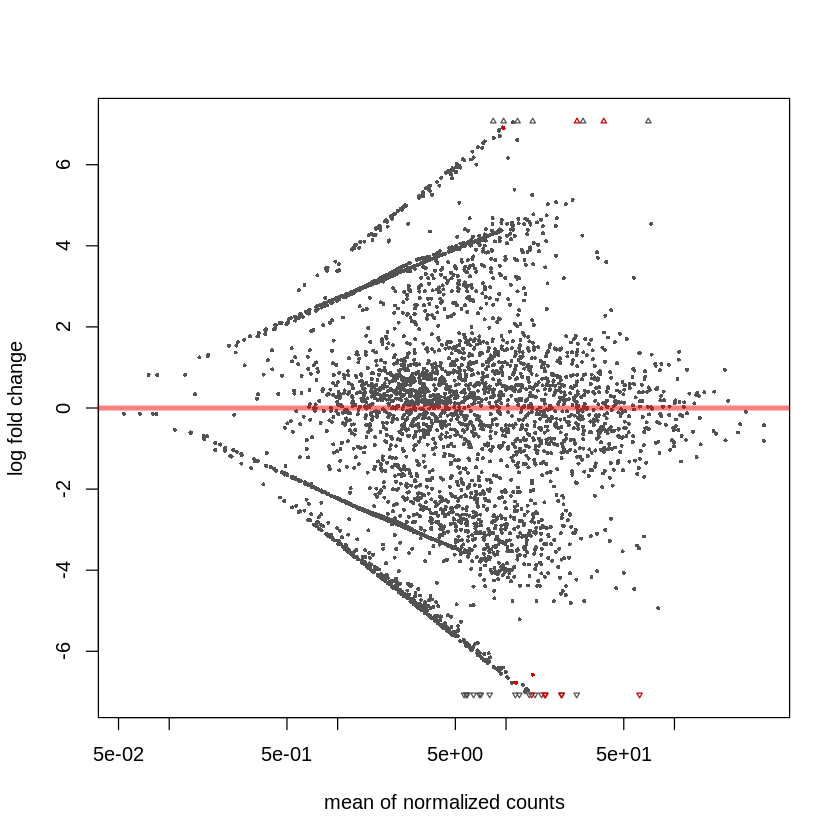

[1] 4


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


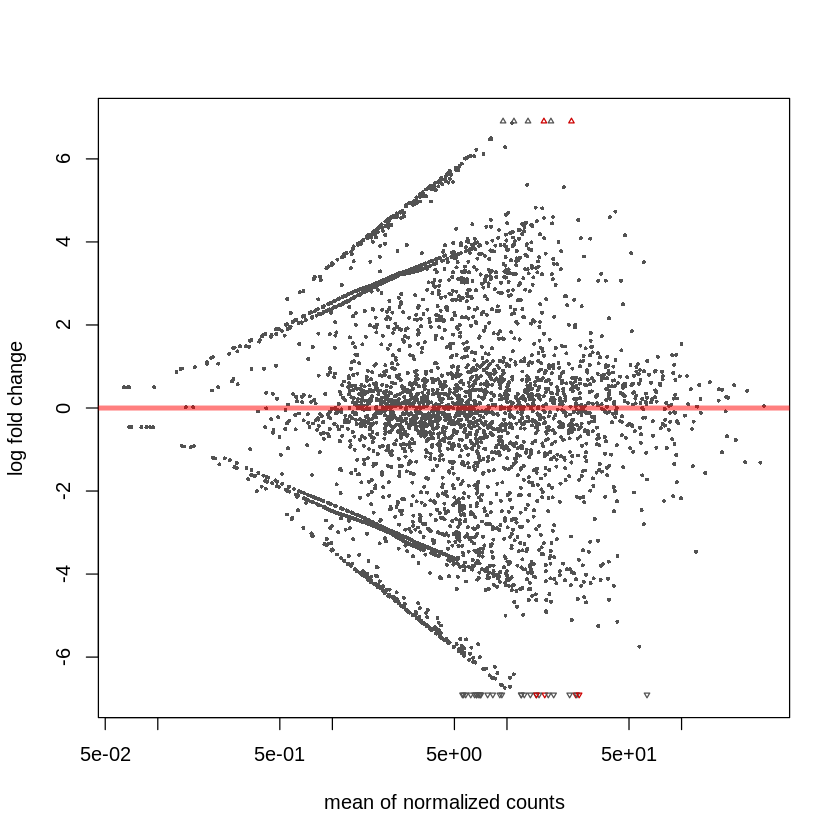

[1] 5


converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


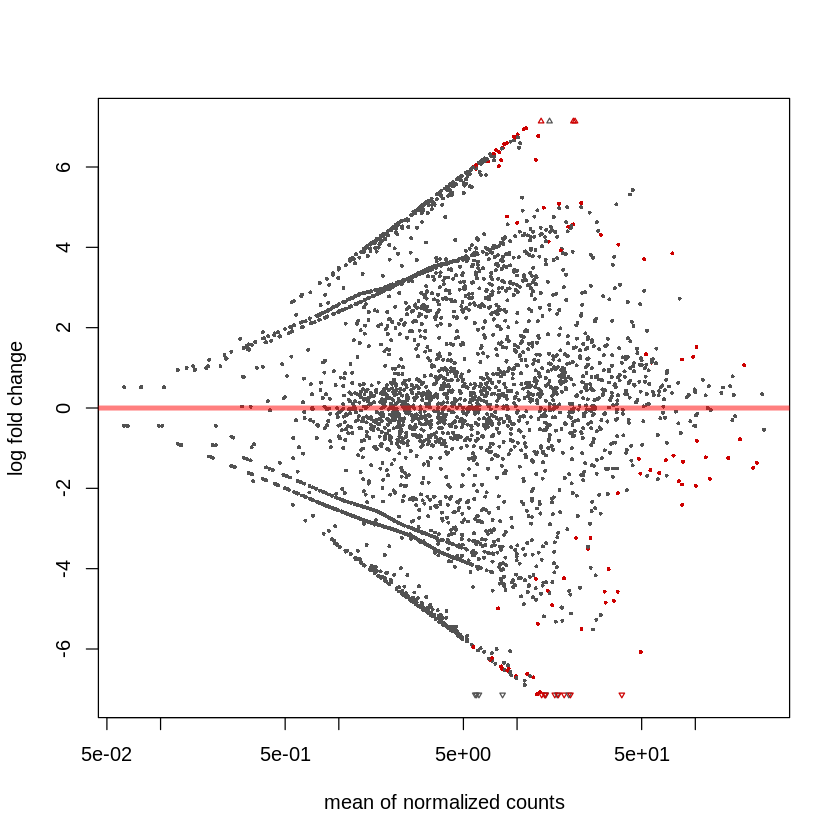

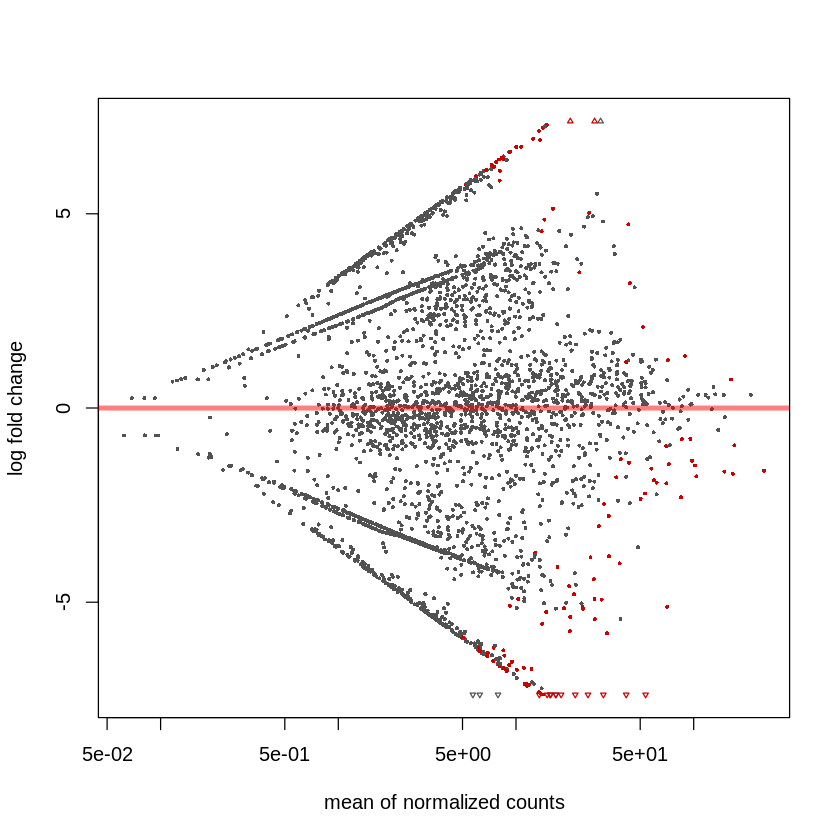

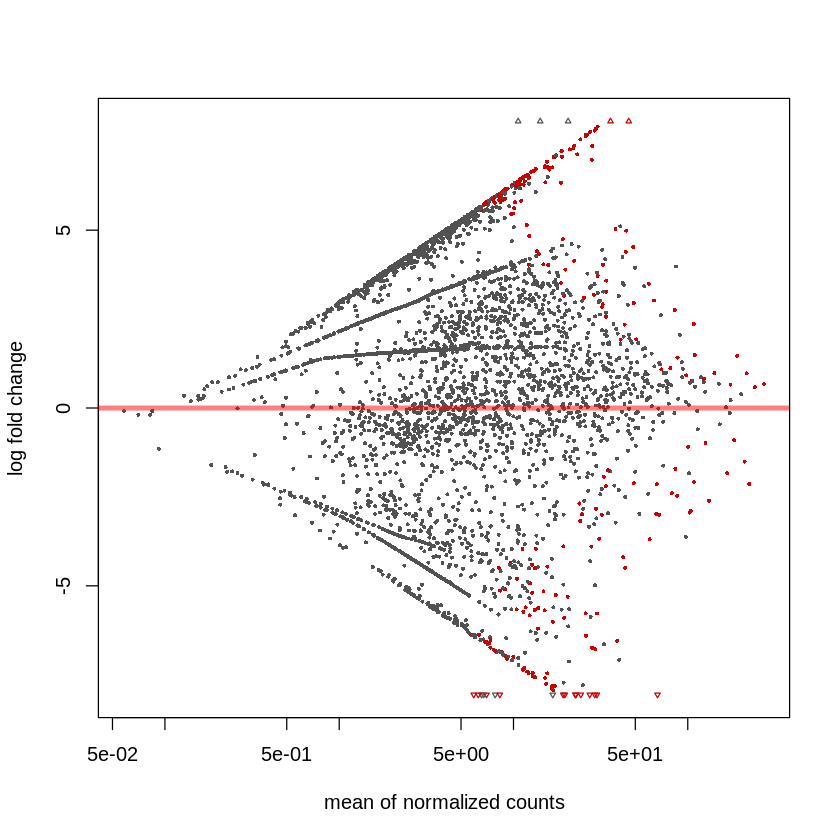

In [189]:

# tmp2 = subset_samples(tmp, SampleType %in% c("BP", "CS"))
#         diagdds = phyloseq_to_deseq2(tmp2, ~ SampleType + Plate)
#         diagdds = DESeq(diagdds, fitType="local")
        # get log2 fold change between this pair of genotypes
        
 
# Loop script for specific contrasts
df.l2fc = NULL



#create DESeq dataset and DESeq object
TimeList = c(1,2,3,4,5)
#set up list to store results output
#myresults = paste(FungusList, ".res", sep = "") %>% as.list()


    for (i in TimeList) {

        print(i)
        phy = subset_samples(tmp, TimePoint == i & SampleType %in% c("BP", "CS"))
        sample_data(phy)$Plate = ifelse(sample_data(phy)$Rep %in% c(1,2,3), "A", "B")
        # tmp2 = subset_samples(tmp, SampleType %in% c("BP", "CS"))

        diagdds = phyloseq_to_deseq2(phy, ~ SampleType + Plate)
        diagdds = DESeq(diagdds, fitType="local")
        # get log2 fold change between this pair of genotypes
        res =  results(diagdds,contrast=c('Plate',"B","A"), lfcThreshold = 0)

        r =   res %>% as.data.frame %>%
               mutate(ASV=row.names(.), Time = i, Experiment = '2')
        #Store results for each fungus in list, e.g. myresults$Gv
        #myresults[FungusList[i]] = res
        plotMA(res)
        df.l2fc = rbind(df.l2fc, r)
    }
    

df.l2fc.2.BPCS = df.l2fc

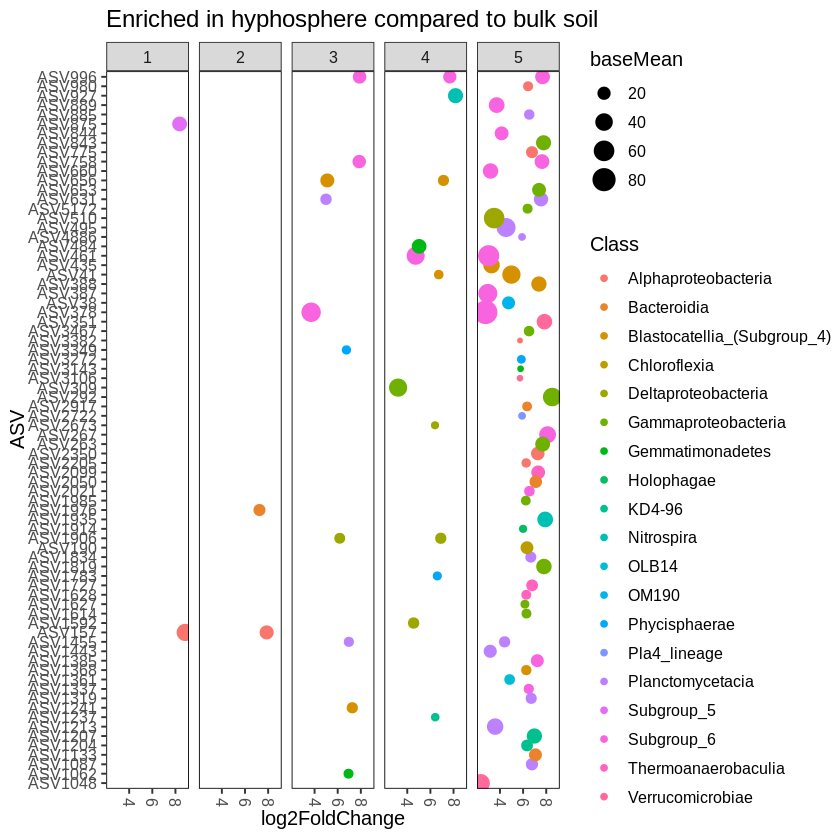

In [191]:
df = left_join(df.l2fc,taxa, by = "ASV")
sigtab = df %>% filter(padj < 0.05 & log2FoldChange > 2) #& Order %in% 
                     #   c("Myxococcales", "Betaproteobacteriales", "Rhizobiales", "Sphingomonadales", 
                     #    "Fibrobacterales", "Cytophagales")) %>% mutate(Order = droplevels(Order))

x = tapply(sigtab$log2FoldChange, sigtab$Order, function(x) max(x))
x = sort(x, TRUE)
sigtab$Order = factor(as.character(sigtab$Order), levels=names(x))
# x = tapply(sigtab$log2FoldChange, sigtab$Rank3, function(x) max(x))
# x = sort(x, TRUE)
# sigtab$Rank3 = factor(as.character(sigtab$Rank3), levels=names(x))
#cs = brewer.pal(12,"Set3")    
p2 = ggplot(sigtab, aes(x=log2FoldChange, y=ASV, size = baseMean)) + 
    geom_point(aes(color = Class))+
  theme_pub(base_size = 12) +
  #scale_color_manual(values = cs) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5)) + 
  facet_wrap(~Time, ncol = 5)+
    ggtitle("Enriched in hyphosphere compared to bulk soil")  +
   theme(legend.position="right")# +
        #guides(color=guide_legend(ncol=3)) 
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x
    p2

In [192]:
sigtab %>% filter(Time == 1)

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,ASV,Time,Experiment,Kingdom,Phylum,Class,Order,Family,Genus
26.39417,8.360069,1.467782,5.695716,1.228551e-08,4.452546e-06,ASV875,1,2,Bacteria,Acidobacteria,Subgroup_5,NA,NA,NA
38.05630,8.844546,1.138191,7.770706,7.804995e-15,4.983489e-12,ASV157,1,2,Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Phenylobacterium
